---
# Code Title: DED-LB particle stream diameter measurement using Python OpenCV

Project: Prediction of the Powder Catchment Efficiency and Melt Track Height in Laser Directed Energy Deposition

Code created by: Colin Ancalmo

Last edited: 08/24/2024

## Overview:
This code extracts the Particle stream diameter from back-illuminated high speed video franes across different powder deposition parameters.
The code is published for research reproducibility of the high-speed image analysis in corresponding project manuscript. 
For evaluating the code, the raw high-speed imaging data for the 67 - 80 um powder under a carrier gas flow rate of 6 L/min is available for download from the data repository folder "HighSpeedDataForGitLabCode".

---
#### File Inputs:
- `1_Data_in/0_BackgroundScale/`: set of background images per high speed video, to perform background subtraction
- `1_Data_in/1_HighSpeedFrames/`: Dataset of high speed images

#### File Outputs: 
- `2_Results_out/PowderSpotDia_Results/`: Generated Particle stream distribution, and stream diameter data 12mm below nozzle
---

## Required Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import datetime
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tqdm import tqdm
%matplotlib inline

### Functions

In [2]:
#################################### [Helper Functions] ####################################

# Define the Gaussian function
def gaussain(x, offset, amplitude, x_center, sigma):
    return offset + amplitude*np.exp((-(x - x_center)**2) / (2*sigma**2))

def gaussain_fit(x, y):
    mean = sum(x*y)/sum(y)
    sigma = (sum(y*(x - mean)**2) / sum(y))**(1/2)
    return curve_fit(gaussain, x, y, p0=[min(y), max(y), mean, sigma])[0]

#################################### [Main Function] ####################################
def StreamAnalysisPipeline(TrialName, PowderDeposition_Metadata, Imaging_Metadata, data_files, BG_file, AnalysisPercent=1):
    """
    Compute the particle stream spot diameter at specified standoff distance.
    Args:
        TrialName: User-defined Metadata Trial Title
        PowderDeposition_Metadata: Set of deposition parameters
        Imaging_Metadata: Set of high-speed imaging parameters
        data_files: file path of high speed image frames, in an image sequence
        BG_file: file path of background image, to perform background subtraction
        **AnalysisPercent: Percent of image frames to analyze. Used for debugging
    Returns:
        DataSummary_df: Dataframe containing process parameters and particle stream diameter
    Saves:
        blended_img... .tif: Raw 32bit image of the particle stream distribution
        notated_img... .png: Annotated 8bit image of the particle stream distribution
        FocalPlane_img... .png: plot of the gaussian fit of the particle stream distribution at the measured standoff distance
        SpotData... .cvs: Raw pixel data at the standoff distance
        Summary... .cvs: DataSummary_df
    """

    #Load metadata
    Exp_MachineState = Imaging_Metadata["Exp_MachineState"]
    framerate = Imaging_Metadata["framerate_Hz"]
    VidExposure = Imaging_Metadata["VidExposure_us"]
    PixelScale = Imaging_Metadata["PixelScale_pixmm"]
    img_duration_s = Imaging_Metadata["img_duration_s"]
    EndofNozzle_Pos_RowPix = Imaging_Metadata["EndofNozzle_Pos_RowPix"]
    CarrierGasFR = PowderDeposition_Metadata["CarrierGasFR_lmin"]
    PowderStr = PowderDeposition_Metadata["PowderStr"]
    ShieldGasFR = PowderDeposition_Metadata["ShieldGasFR_lmin"]
    PowderMassFR = PowderDeposition_Metadata["PowderMassFR_gmin"]
    Code_RunNote = f"{framerate}fps_{VidExposure}us_"
    Exp_FileLabel = str(TrialName)+"_"

    Start_Frame = 0 
    End_Frame = int(framerate*img_duration_s*AnalysisPercent) 
    Start_sec, End_sec = round(Start_Frame/framerate, 1), round(End_Frame/framerate, 1)

    #################################### [Image Processing Pipeline] ####################################

    # Create Output Folder
    parent_path = "2_Results_out/PowderSpotDia_Results/" # Parent folder path
    ct = datetime.datetime.now() #timestamp to prevent file overwriting
    timestamp = str(ct.month)+"-"+str(ct.day)+"_"+str(ct.hour)+"_"+str(ct.minute)+"_"+str(ct.second)
    folder = "SpotDia_" + Exp_FileLabel + Code_RunNote + timestamp  # Folder name
    save_path = parent_path + folder + "/"
    path = os.path.join(parent_path, folder)
    os.mkdir(path) # Create the folder
    print(f"Directory {folder} created")

    #################################### [Image Binarization] ####################################
    #Takes in original images, crops them, and populating matrix of Binarized images in "binary_img_Stack"
    #print("Cropping and Binarizing, then calculating blended image for frames " + str(Start_Frame) + "-" + str(End_Frame))

    binary_img_Stack = [] #create and empty image data between runs
    files = glob.glob (data_files, recursive=True) # Import all .tif file paths
    for my_file in tqdm(files[Start_Frame:End_Frame]): 
        cv2.waitKey(5)
        img_raw = cv2.imread(my_file, -1) #read 12bit image
        
        # Load current video frame and apply background subtraction
        InvBG_img = 4096 - cv2.imread(BG_file, -1)
        img_gray = cv2.rotate((img_raw + InvBG_img), cv2.ROTATE_90_CLOCKWISE)
        img_gray[img_gray > 4095] = 2**12 - 1 #Clamp oversaturated background

        #Apply adaptive thresholding: 
        BGsub_img_img8b = (img_gray/16).astype('uint8') # uint8 required for cv2.adaptiveThreshold
        binary_img8b = cv2.adaptiveThreshold(BGsub_img_img8b, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 33) #kernal is 3x larger than largest particle, C tuned on L-CG10, C-CG2
        binary_img_Stack.append(binary_img8b) #Binarized 
        cv2.destroyAllWindows()

    #################################### [Calculate particle stream spatial disctribution image] ####################################
    
    accumulator = np.zeros_like(binary_img_Stack[0], dtype=np.uint32) #High-bit-depth array to add all pixel values
    for i in range(Start_Frame,End_Frame):
        accumulator = accumulator + binary_img_Stack[i]
    blended_img_32bit = accumulator / len(range(Start_Frame,End_Frame)) # Dividing image values by total frames (bringing back to 0-255 limit)
    #blended_img_32bit_inv = 255-blended_img_32bit
    #blended_img_32bit = (blended_img_32bit_inv / np.max(blended_img_32bit_inv) ) + 255 #normalize to 0-1

    blended_img_32bit = (blended_img_32bit.copy() - np.min(blended_img_32bit)) / (np.max(blended_img_32bit) - np.min(blended_img_32bit)) #normalize to 0-1

    #################################### [Analyze particle stream spatial disctribution for stream diameter] ####################################

    ### Finding the Powder Focal Plane (minimum powder spot distribution) ###
    # Inspecting pixel values at specified distance from nozzle
   
    StandoffDistance_Ypix = int(EndofNozzle_Pos_RowPix + 12*PixelScale + 1) # 12mm below the nozzle exit, in row pixels. Since the nozzle is out of view, this acts as the Z reference.
    Y_inspect_cen = np.linspace(-65, 65, 27) + StandoffDistance_Ypix #~10-14 mm search
    Y_inspect_cen.astype(int) #to integers

    # get rectangular sample of particle stream distribution at the standoff distance
    SampleWidthAdd = 2  #additional Y pixel rows (+/-) sampled (+0=1, +1=3, +2=5...)
    y_slice_pix = blended_img_32bit[(StandoffDistance_Ypix-SampleWidthAdd):(StandoffDistance_Ypix+SampleWidthAdd+1) , 
                                1:len(blended_img_32bit[StandoffDistance_Ypix,:])] 
    y_slice_pix_inv_12mm = 1 - np.mean(y_slice_pix, axis=0)  #inverting pixel brightness to pixel 'darkness'

    # Apply gaussian fit to the particle distribution slice
    x_length, y_length = len(blended_img_32bit[0,:]), len(blended_img_32bit[:,0])
    x_pix = np.linspace(0,x_length-2, x_length-1)
    xdata, ydata = x_pix, y_slice_pix_inv_12mm
    H, A, mean, StDev_12mm = gaussain_fit(xdata, ydata)

    Standoff_pix_12mm = StandoffDistance_Ypix #Stats at 12mm from nozzle
    e2SpotDiameter_At12mm = round( (StDev_12mm*2*2)/PixelScale , 3) #e^-2 contour of distribution, assuming 2D slice of 3D gaussian.

    #Gaussian Goodness of Fit at focal plane
    y_fit = gaussain(x_pix, *gaussain_fit(x_pix, y_slice_pix_inv_12mm))
    GaussFit_RMSE = (np.mean( (y_fit - y_slice_pix_inv_12mm)**2 ))**0.5
    GaussFit_MAE = np.mean(abs(y_fit - y_slice_pix_inv_12mm))
    GaussFit_R2 = 1 - ( sum((y_slice_pix_inv_12mm-y_fit)**2) / sum((y_slice_pix_inv_12mm-np.mean(y_slice_pix_inv_12mm))**2) )

    # Adding spot diameter data to dataframe
    SpotDistributionData = pd.DataFrame() #empty df to be populated below
    SpotDistributionData_current = pd.DataFrame(data = {'X Position mm ' + str(0): x_pix/PixelScale, 
                                                        'Image Pixel Value at 12mm ' + str(0): y_slice_pix_inv_12mm})
    SpotDistributionData = pd.concat([SpotDistributionData, SpotDistributionData_current], axis=1)
    
    ## adding seconds to dataframe
    SecRange = [Start_sec, End_sec]
    SecRangeDF = pd.DataFrame(data = {'Start_End_Seconds ' + str(0): SecRange})
    SpotDistributionData = pd.concat([SpotDistributionData, SecRangeDF], axis=1)

    #################################### [FIGURE PLOTTING] ####################################
    
    ## Figure 1: Notated image with inspection bounding box
    Ymin, Ymax = 0, np.shape(blended_img_32bit)[0]      #Image matrix Rows=Y 
    Xmin, Xmax = 0, np.shape(blended_img_32bit)[1]      #Image matrix Columns=X

    # Ensure 32-bit image is within 0-255 range for 8-bit conversion
    blend_img_temp = blended_img_32bit * 255 #* (255 / (blended_img_32bit.max()-blended_img_32bit.min()))
    blend_img_temp = blend_img_temp.copy() - blend_img_temp.min()
    notated_image = cv2.cvtColor(blend_img_temp.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    cv2.rectangle(notated_image, (0, Standoff_pix_12mm-SampleWidthAdd-1), (x_length, Standoff_pix_12mm+SampleWidthAdd+1), (0,0,255), 1) #Spot Sampling Window

    rcParams['font.family'] = 'serif'
    px = 1/plt.rcParams['figure.dpi']  # plot's default pixel-per-inches
    fig, ax = plt.subplots(figsize=(x_length*px, y_length*px)) #plotting figure pixel-perfect

    def pix2mm(pix):
        mm = pix / PixelScale
        return mm
    def mm2pix(mm):
        pix = mm * PixelScale
        return pix

    Title_text = "Powder Stream Distribution: " + str(round(Start_sec,1)) +"-"+ str(round(End_sec,1)) + " Seconds"
    Exp_Parameters = f"Parameters:\nPowder: {PowderStr}, PMFR: {str(PowderMassFR)} g/min, SGFR: {str(ShieldGasFR)} L/min, CGFR: {str(CarrierGasFR)} L/min\nFrame Rate: {str(framerate)} fps, Exposure: {str(VidExposure)} μs,"
    SubTitle_text = str(Exp_Parameters + " " + Exp_MachineState)

    plt.suptitle(Title_text, y=1.015, fontsize=14) #main title 
    plt.title(SubTitle_text, fontsize=10) #sub-title
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)
    secax_X = ax.secondary_xaxis('top', functions=(pix2mm, mm2pix))
    secax_Y = ax.secondary_yaxis('right', functions=(pix2mm, mm2pix))
    secax_X.set_xlabel('X [mm]', fontsize=12)
    secax_Y.set_ylabel('Y [mm]', fontsize=12)
    ax.imshow(notated_image, interpolation='none', extent=[(Xmin - Xmax/2), (Xmin + Xmax/2), Ymax-EndofNozzle_Pos_RowPix, Ymin-EndofNozzle_Pos_RowPix])
    plt.show()

    ## Figure 2: Fitted Gaussian distribution
    fig_focal, ax_focal = plt.subplots(figsize=(5,5)) #for focal plane plotting

    plt.plot( xdata, ydata, '.')
    plt.plot( xdata, gaussain(xdata, *gaussain_fit(xdata, ydata)), 'b', label= round((StandoffDistance_Ypix-EndofNozzle_Pos_RowPix)/PixelScale, 1) )
    plt.title( "Powder Spot Distribution at 12 mm below the Nozzle\nFrom " + str(round(Start_sec,1)) +"-"+ str(round(End_sec,1)) + " Seconds" )
    plt.xlabel("X Pixels")
    plt.ylabel("Normalized Particle Distribution")
    plt.legend(title="Distance from Nozzle", title_fontsize='small', prop={'size': 6})
    plt.show()

    FrameTag = "f" + str(Start_Frame) + "-f" + str(End_Frame) + "_"
    FocalPlaneImg_filename = "FocalPlane_img_" + FrameTag + Exp_FileLabel + ".png"
    fig_focal.savefig(save_path + FocalPlaneImg_filename, bbox_inches='tight')

    #################################### [FILE WRITING per step] ####################################

    #ProcessImg_filename = "blended_img_" + FrameTag + Exp_FileLabel + ".tif"
    ProcessImg_filename_32bit = "blended_img_" + FrameTag + Exp_FileLabel + "_32bit.tif"
    NotatedImg_filename = "notated_img_" + FrameTag + Exp_FileLabel + ".png"
    
    cv2.imwrite(save_path + ProcessImg_filename_32bit, blended_img_32bit) #Save raw averaged image in 32bit
    fig.savefig(save_path + NotatedImg_filename, bbox_inches='tight') #Saves plot below

    DataSummary_df = pd.DataFrame(data = { 'Trial':[TrialName],
                                        'VidExposure':VidExposure,
                                        'SGFR':ShieldGasFR,
                                        'CGFR':CarrierGasFR,
                                        'PMFR':PowderMassFR,
                                        'e2SpotDia_12mm': e2SpotDiameter_At12mm,
                                        'e2SpotDia_12mmFit_RSME':GaussFit_RMSE,
                                        'e2SpotDia_12mmFit_MAE':GaussFit_MAE,
                                        'e2SpotDia_12mmFit_R2':GaussFit_R2})

    SpotDistribution_filename = "SpotData_" + Exp_FileLabel + Code_RunNote + ".csv"
    Summary_filename = "Summary_" + Exp_FileLabel + Code_RunNote + ".csv"
    SpotDistributionData.to_csv(save_path + SpotDistribution_filename) #Save raw inspected image data
    DataSummary_df.to_csv(save_path + Summary_filename) #Save summarized data

    ### FINAL STATS ###
    print("-- ", Exp_FileLabel, " FINAL STATS (mean +/- 1 Standard Deviation) --")
    print("Powder Spot Diameter at 12mm standoff:", round(e2SpotDiameter_At12mm,3), "+/-", round(StDev_12mm / PixelScale,3))

    return DataSummary_df

#end

Directory SpotDia_SO12_M_CG6_Free_14400fps_1.99us_8-24_19_50_38 created


100%|██████████| 14400/14400 [05:39<00:00, 42.47it/s]


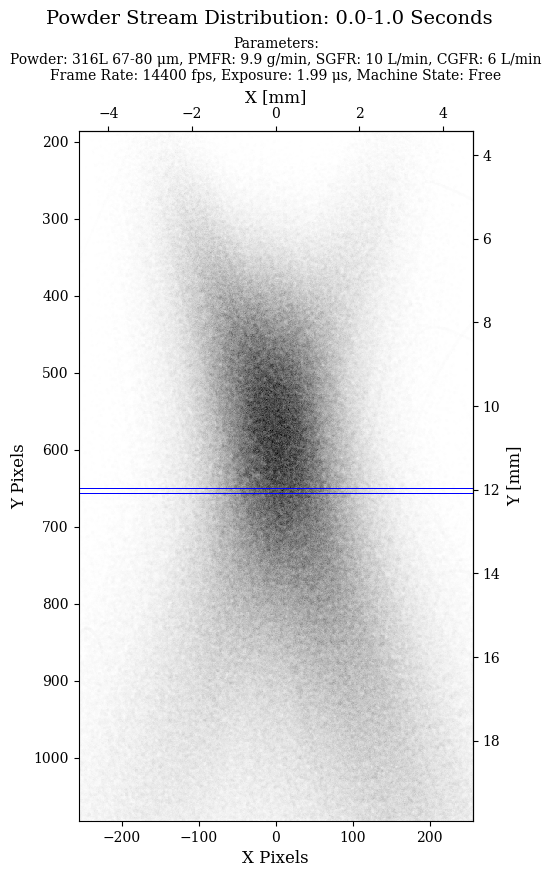

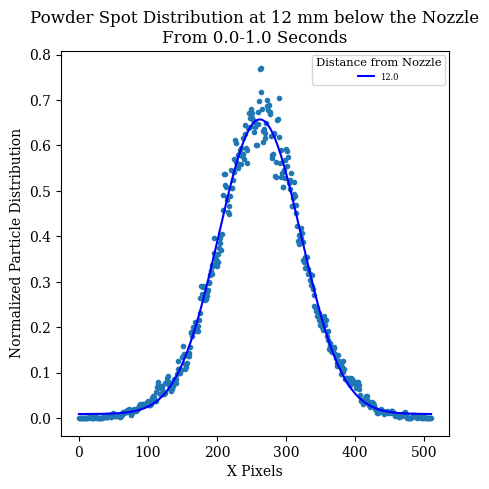

--  SO12_M_CG6_Free_  FINAL STATS (mean +/- 1 Standard Deviation) --
Powder Spot Diameter at 12mm standoff: 4.396 +/- 1.099


,Trial,VidExposure,SGFR,CGFR,PMFR,e2SpotDia_12mm,e2SpotDia_12mmFit_RSME,e2SpotDia_12mmFit_MAE,e2SpotDia_12mmFit_R2
0,SO12_M_CG6_Free,1.99,10,6,9.9,4.396,0.022523,0.015389,0.990144


In [3]:
#################################### [USER INPUTS] ####################################

Imaging_Metadata = {
    "Exp_MachineState": "Machine State: Free",  # Machine State Metadata
    "framerate_Hz": 14400,                      # Imaging Frame Rate [Hz]
    "VidExposure_us": 1.99,                     # Imaging Exposure [μs]
    "PixelScale_pixmm": (652/12),               # Imaging pixel resolution [pixel/mm]
    "img_duration_s": 1,                        # Imaging duration [s]
    "EndofNozzle_Pos_RowPix": -186              # Position of bottom of nozzle with respect to the top of the high-speed imaging field of view (negative = out of recorded field of view)
}

AnalysisPercent = 1 # Percent of frames to analyze. Useful for debugging. 

# Static Parameters:
ShieldGasFR = 10    #l/min
PowderMassFR = 9.9  #g/min #Average

#################################### [FACTORIAL CASE ANALYSIS] ####################################
TrialName = "SO12_M_CG6_Free"
PowderDeposition_Metadata = {"CarrierGasFR_lmin": 6, "PowderStr": '316L 67-80 μm', "ShieldGasFR_lmin": ShieldGasFR, "PowderMassFR_gmin": PowderMassFR}
BG_file = '1_Data_in/0_BackgroundScale/BG_Free_316L-M_10gmin_SG10_CG6.tif' #Background image
data_files = '1_Data_in/1_HighSpeedFrames/316L_M_10gmin_SG10_CG6_14400fps_Free_/*.tif' #Video frames

StreamAnalysisPipeline(TrialName, PowderDeposition_Metadata, Imaging_Metadata, data_files, BG_file, AnalysisPercent)

End of code